In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn.objects as so
from scipy import stats
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

In [3]:
# 데이터 로드
train = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\train.csv')
test = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\test.csv')

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (630000, 13)
Test: (270000, 12)


In [4]:
# 수치형 변수만 추출
numeric_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
X_numeric = train[numeric_cols].copy()

X_numeric.describe()

,age,study_hours,class_attendance,sleep_hours
count,630000.000000,630000.000000,630000.000000,630000.000000
mean,20.545821,4.002337,71.987261,7.072758
std,2.260238,2.359880,17.430098,1.744811
min,17.000000,0.080000,40.600000,4.100000
25%,19.000000,1.970000,57.000000,5.600000
50%,21.000000,4.000000,72.600000,7.100000
75%,23.000000,6.050000,87.200000,8.600000
max,24.000000,7.910000,99.400000,9.900000


In [5]:
# 스케일링 (클러스터링 전 필수)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

print("스케일링 완료")

스케일링 완료


In [6]:
# 최적 클러스터 수 탐색 (Elbow Method)
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

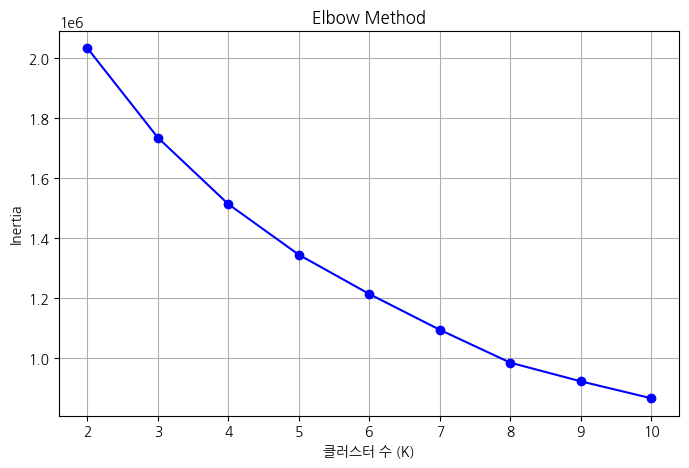

In [7]:
# Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('클러스터 수 (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [9]:
# Silhouette Score (10000개 샘플로 빠르게 계산)
from sklearn.metrics import silhouette_score

sample_size = 10000
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_idx]

silhouette_scores = []
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette = {score:.4f}")

K=2: Silhouette = 0.1891
K=3: Silhouette = 0.1851
K=4: Silhouette = 0.1909
K=5: Silhouette = 0.1940
K=6: Silhouette = 0.2006
K=7: Silhouette = 0.2104
K=8: Silhouette = 0.2237
K=9: Silhouette = 0.2142
K=10: Silhouette = 0.2149


In [10]:
# K=4로 클러스터링 수행
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
train['cluster'] = kmeans.fit_predict(X_scaled)

print(f"클러스터별 샘플 수:")
print(train['cluster'].value_counts())
print(train['cluster'].value_counts().sort_index())

클러스터별 샘플 수:
cluster
3    160718
0    159400
1    155699
2    154183
Name: count, dtype: int64
cluster
0    159400
1    155699
2    154183
3    160718
Name: count, dtype: int64


In [11]:
# 클러스터별 exam_score 분포 확인
cluster_stats = train.groupby('cluster')['exam_score'].agg(['mean', 'std', 'count'])
cluster_stats = cluster_stats.round(2)
print("클러스터별 시험 점수 통계:")
print(cluster_stats)

클러스터별 시험 점수 통계:
          mean    std   count
cluster                      
0        48.36  15.98  159400
1        66.81  17.58  155699
2        67.75  16.97  154183
3        67.34  17.55  160718


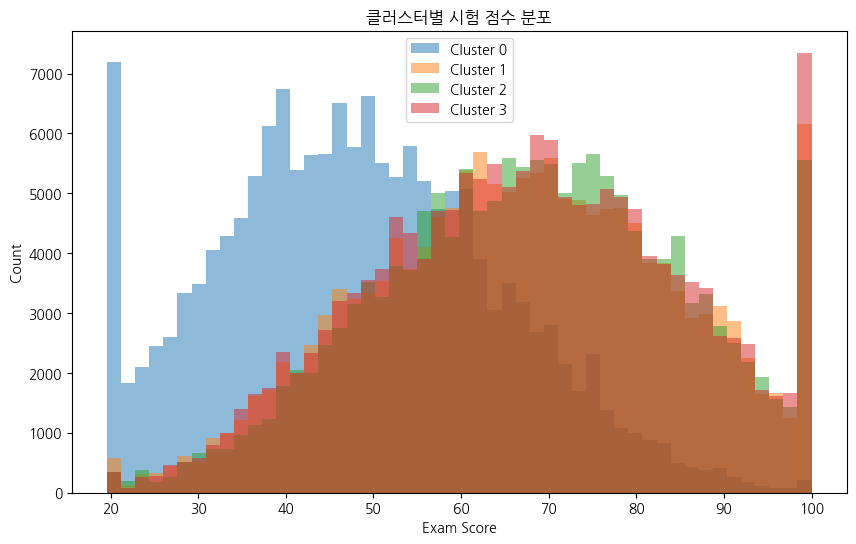

In [12]:
# 클러스터별 점수 분포 시각화
fig, ax = plt.subplots(figsize=(10, 6))
for c in range(n_clusters):
    subset = train[train['cluster'] == c]['exam_score']
    ax.hist(subset, bins=50, alpha=0.5, label=f'Cluster {c}')

ax.set_xlabel('Exam Score')
ax.set_ylabel('Count')
ax.set_title('클러스터별 시험 점수 분포')
ax.legend()
plt.show()

In [13]:
# 클러스터별 변수 특성 확인
cluster_profile = train.groupby('cluster')[numeric_cols].mean().round(2)
print("클러스터별 평균 프로파일:")
print(cluster_profile)

클러스터별 평균 프로파일:
           age  study_hours  class_attendance  sleep_hours
cluster                                                   
0        20.56         2.85             54.06         5.94
1        18.35         4.30             74.18         8.42
2        20.57         4.52             85.64         5.42
3        22.64         4.35             74.54         8.47


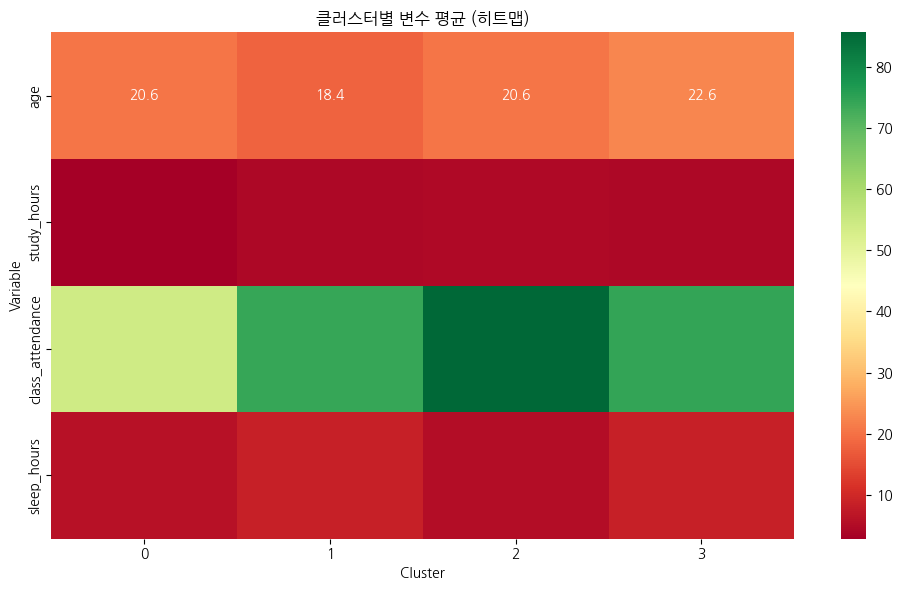

In [14]:
# 클러스터 프로파일 히트맵
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cluster_profile.T, annot=True, cmap='RdYlGn', fmt='.1f', ax=ax)
ax.set_title('클러스터별 변수 평균 (히트맵)')
ax.set_xlabel('Cluster')
ax.set_ylabel('Variable')
plt.tight_layout()
plt.show()

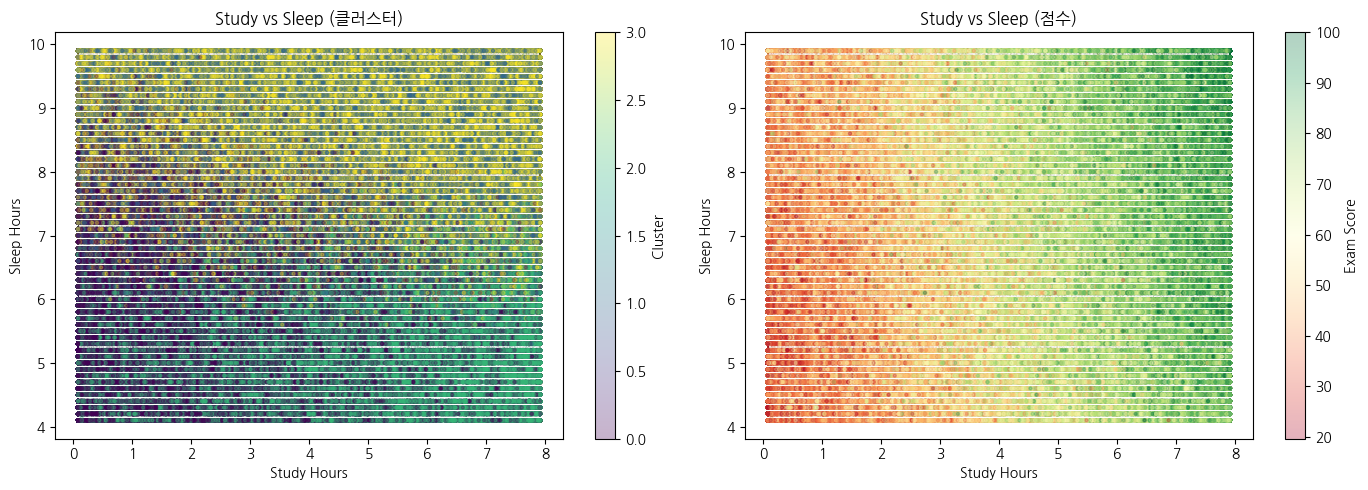

In [15]:
# 2D scatter: study_hours vs sleep_hours (클러스터 색상)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 클러스터별 색상
scatter1 = axes[0].scatter(train['study_hours'], train['sleep_hours'], 
                           c=train['cluster'], cmap='viridis', alpha=0.3, s=5)
axes[0].set_xlabel('Study Hours')
axes[0].set_ylabel('Sleep Hours')
axes[0].set_title('Study vs Sleep (클러스터)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# exam_score별 색상
scatter2 = axes[1].scatter(train['study_hours'], train['sleep_hours'], 
                           c=train['exam_score'], cmap='RdYlGn', alpha=0.3, s=5)
axes[1].set_xlabel('Study Hours')
axes[1].set_ylabel('Sleep Hours')
axes[1].set_title('Study vs Sleep (점수)')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

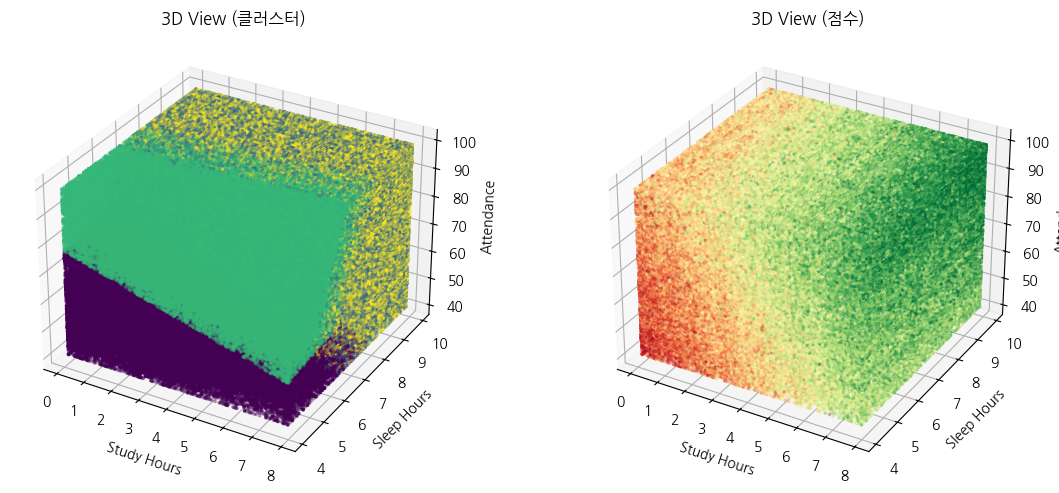

In [16]:
# 3D 시각화: 다차원에서 군집 확인
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

# 클러스터별 색상
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train['study_hours'], train['sleep_hours'], train['class_attendance'],
            c=train['cluster'], cmap='viridis', alpha=0.3, s=3)
ax1.set_xlabel('Study Hours')
ax1.set_ylabel('Sleep Hours')
ax1.set_zlabel('Attendance')
ax1.set_title('3D View (클러스터)')

# 점수별 색상
ax2 = fig.add_subplot(122, projection='3d')
sc = ax2.scatter(train['study_hours'], train['sleep_hours'], train['class_attendance'],
                 c=train['exam_score'], cmap='RdYlGn', alpha=0.3, s=3)
ax2.set_xlabel('Study Hours')
ax2.set_ylabel('Sleep Hours')
ax2.set_zlabel('Attendance')
ax2.set_title('3D View (점수)')

plt.tight_layout()
plt.show()

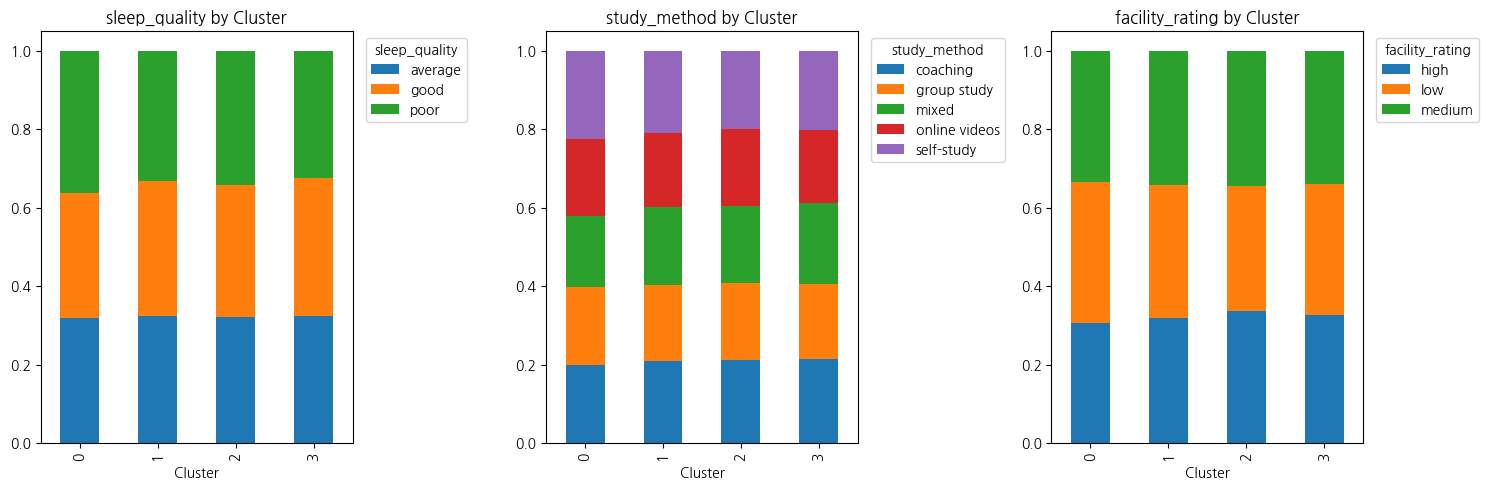

In [17]:
# 범주형 변수별 클러스터 분포 확인
cat_cols = ['sleep_quality', 'study_method', 'facility_rating']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(train['cluster'], train[col], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{col} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].legend(title=col, bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

## 클러스터 기반 인사이트 정리

위 분석을 통해 다음을 확인:
1. 클러스터별 exam_score 분포가 다른지
2. 클러스터가 어떤 특성(study_hours, sleep_hours 등)으로 구분되는지
3. 3D에서 봤을 때 군집이 점수와 어떻게 연관되는지

이를 바탕으로 클러스터 자체를 파생변수로 활용하거나, 클러스터별 특성을 반영한 새로운 변수를 생성할 수 있다.

In [18]:
# 클러스터별 중심점으로부터의 거리 계산 (새로운 파생변수)
centers = kmeans.cluster_centers_

# 각 샘플의 해당 클러스터 중심까지의 거리
train['dist_to_center'] = np.linalg.norm(X_scaled - centers[train['cluster']], axis=1)

# 클러스터별 평균 점수를 인코딩
cluster_score_map = train.groupby('cluster')['exam_score'].mean().to_dict()
train['cluster_mean_score'] = train['cluster'].map(cluster_score_map)

print("파생변수 추가 완료:")
print("- dist_to_center: 클러스터 중심까지의 거리")
print("- cluster_mean_score: 해당 클러스터의 평균 점수")

파생변수 추가 완료:
- dist_to_center: 클러스터 중심까지의 거리
- cluster_mean_score: 해당 클러스터의 평균 점수


In [19]:
# 새 파생변수와 exam_score 상관관계 확인
print("파생변수 상관관계:")
print(f"cluster: {train['cluster'].corr(train['exam_score']):.4f}")
print(f"dist_to_center: {train['dist_to_center'].corr(train['exam_score']):.4f}")
print(f"cluster_mean_score: {train['cluster_mean_score'].corr(train['exam_score']):.4f}")

파생변수 상관관계:
cluster: 0.3442
dist_to_center: -0.0396
cluster_mean_score: 0.4354


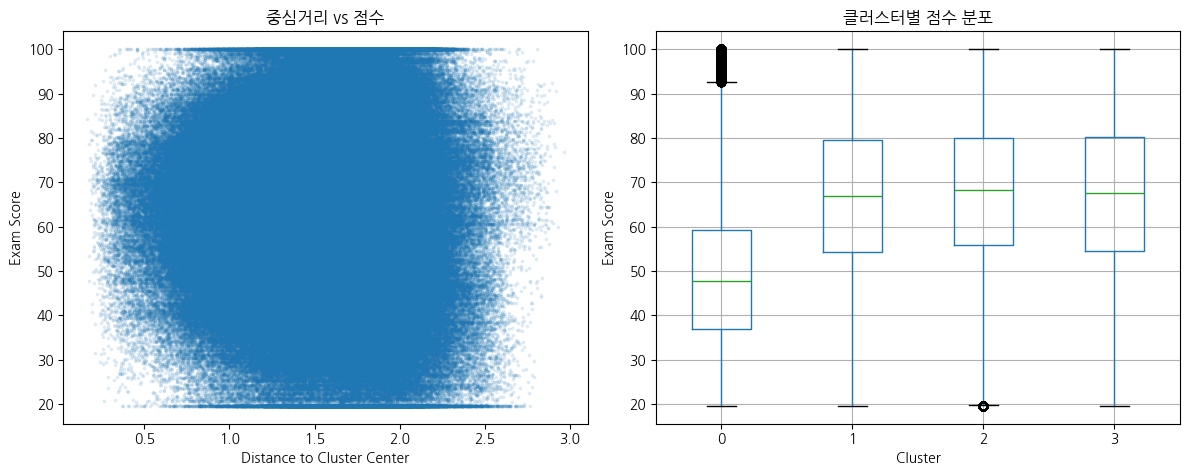

In [20]:
# dist_to_center vs exam_score 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(train['dist_to_center'], train['exam_score'], alpha=0.1, s=3)
axes[0].set_xlabel('Distance to Cluster Center')
axes[0].set_ylabel('Exam Score')
axes[0].set_title('중심거리 vs 점수')

# 클러스터별 boxplot
train.boxplot(column='exam_score', by='cluster', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Exam Score')
plt.suptitle('')
axes[1].set_title('클러스터별 점수 분포')

plt.tight_layout()
plt.show()

## PCA로 차원 축소 후 시각화

더 명확한 패턴을 보기 위해 PCA를 적용해본다.

In [21]:
# PCA 적용
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("설명된 분산 비율:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.4f}")
print(f"  Total: {sum(pca.explained_variance_ratio_):.4f}")

설명된 분산 비율:
  PC1: 0.2780
  PC2: 0.2498
  PC3: 0.2444
  Total: 0.7722


In [22]:
# PCA 컴포넌트별 기여도 확인
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=numeric_cols
)
print("변수별 주성분 기여도:")
print(components_df.round(3))

변수별 주성분 기여도:
                    PC1    PC2    PC3
age              -0.097 -0.992 -0.074
study_hours      -0.653  0.071 -0.200
class_attendance -0.625  0.097 -0.380
sleep_hours      -0.416 -0.025  0.900


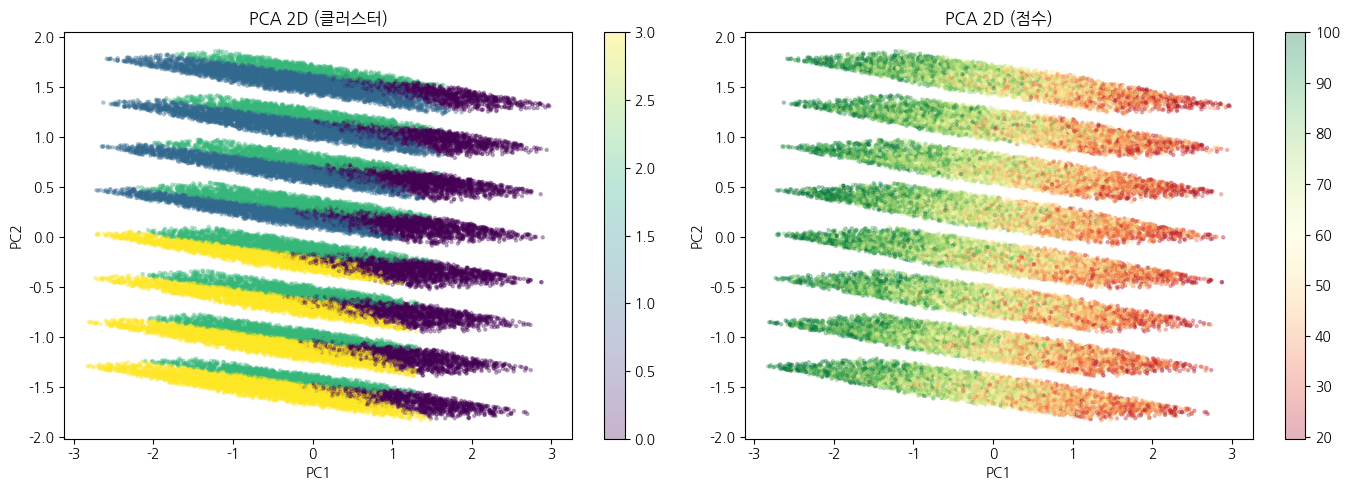

In [23]:
# PCA 2D 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 샘플링 (시각화 속도)
sample_idx = np.random.choice(len(train), 50000, replace=False)

# 클러스터별
scatter1 = axes[0].scatter(X_pca[sample_idx, 0], X_pca[sample_idx, 1],
                           c=train['cluster'].iloc[sample_idx], cmap='viridis', alpha=0.3, s=5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA 2D (클러스터)')
plt.colorbar(scatter1, ax=axes[0])

# 점수별
scatter2 = axes[1].scatter(X_pca[sample_idx, 0], X_pca[sample_idx, 1],
                           c=train['exam_score'].iloc[sample_idx], cmap='RdYlGn', alpha=0.3, s=5)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('PCA 2D (점수)')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

In [24]:
# PCA 컴포넌트를 파생변수로 추가
train['pc1'] = X_pca[:, 0]
train['pc2'] = X_pca[:, 1]
train['pc3'] = X_pca[:, 2]

# 상관관계 확인
print("PCA 컴포넌트와 exam_score 상관관계:")
for pc in ['pc1', 'pc2', 'pc3']:
    corr = train[pc].corr(train['exam_score'])
    print(f"  {pc}: {corr:.4f}")

PCA 컴포넌트와 exam_score 상관관계:
  pc1: -0.7532
  pc2: 0.0745
  pc3: -0.1408


## 요약: 클러스터링 기반 파생변수

1. **cluster**: K-Means로 생성한 군집 라벨 (4개)
2. **dist_to_center**: 클러스터 중심까지의 거리
3. **cluster_mean_score**: 해당 클러스터의 평균 점수 (타겟 인코딩과 유사)
4. **pc1, pc2, pc3**: PCA 주성분

이 변수들을 기존 파생변수와 함께 모델에 사용해볼 수 있다.